In [37]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src import kitti, stereo

In [38]:
dataset = kitti.KittiDataset(Path('dataset/sequences/00'))
ster = stereo.SGBMStereo(dataset.calib)

In [81]:
pcd = o3d.io.read_point_cloud("full-710-760no-mask.pcd")

In [76]:
pcd = o3d.io.read_point_cloud("full-710-760mask.pcd")

In [83]:

o3d.visualization.draw_geometries([pcd])

(-0.5, 1240.5, 375.5, -0.5)

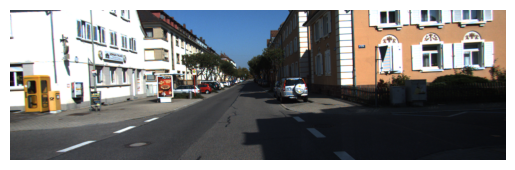

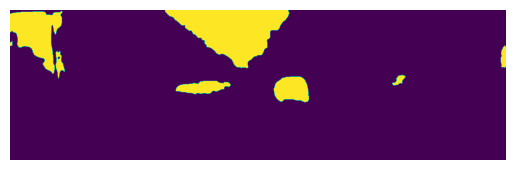

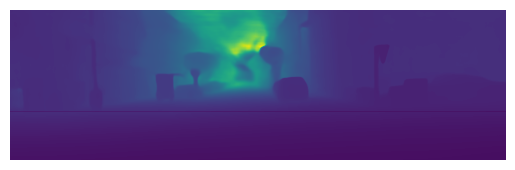

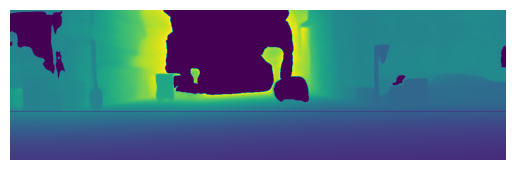

In [80]:
index = 722
mask = np.load("masks/mask%d.npy" % index).astype(np.bool8)
depth = np.load("depth/depth%d.npy" % index).astype(np.float32)
plt.figure(1)
left = cv2.imread("left/000%d.png" % index)
plt.imshow(left)
plt.axis('off')

plt.figure(2)
plt.imshow(mask)
plt.axis('off')

plt.figure(3)
plt.imshow(depth)
plt.axis('off')

plt.figure(4)
depth[mask] = 0
depth[depth > 0.45 * depth.max()] = 0
plt.imshow(depth)
plt.axis('off')

In [42]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [43]:
frame = kitti.KittiFrame(dataset, 645)
pcd = ster.point_cloud(frame, depth)
pcd = pcd.voxel_down_sample(0.00009)

cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd.select_by_index(ind)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])